# NACA 0012 Airfoil Simulation
### Jorge Noriega Quirós

This CFD solver uses the Finite Volume Method (FVM) to numerically solve the incompressible Navier–Stokes equations for steady, laminar flow around a NACA 0012 airfoil.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
%matplotlib inline
%config InLineBackend.figure_format = "svg"

### Pre Processing

In the pre-processing stage, the airfoil geometry is imported by reading its coordinate data (NACA 0012), and a structured O-grid mesh is generated around it. The mesh includes refinement in the wake region to better resolve trailing edge flow behavior.

Boundary conditions are defined for the wall (airfoil), and far-field (which in this case can act as inlet/outlet), and all flow variables are initialized.

Mesh quality metrics—such as y⁺ value (targeting values close to 1 for accurate boundary layer resolution), orthogonality, and skewness—are computed to assess the suitability of the mesh for solving the Navier–Stokes equations.

#### *Generate Model*

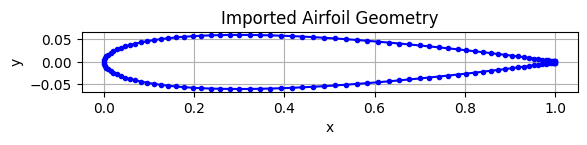

In [18]:
# Import Geometry

filename = "C:\\Documentos\\Programación\\Jupyter Notebooks\\FVM\\NACA 0012\\NACA0012.dat"
# Load coordinates, skipping the first line if it's a title
coords = np.loadtxt(filename, skiprows=1)
# Separate x and y
x = coords[:, 0]
y = coords[:, 1]

# Plot to check
plt.figure()
plt.plot(x, y, 'b.-')
plt.gca().set_aspect('equal')
plt.title("Imported Airfoil Geometry")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

#### *Create Mesh*

Optimized stretching ratio q: 1.1681


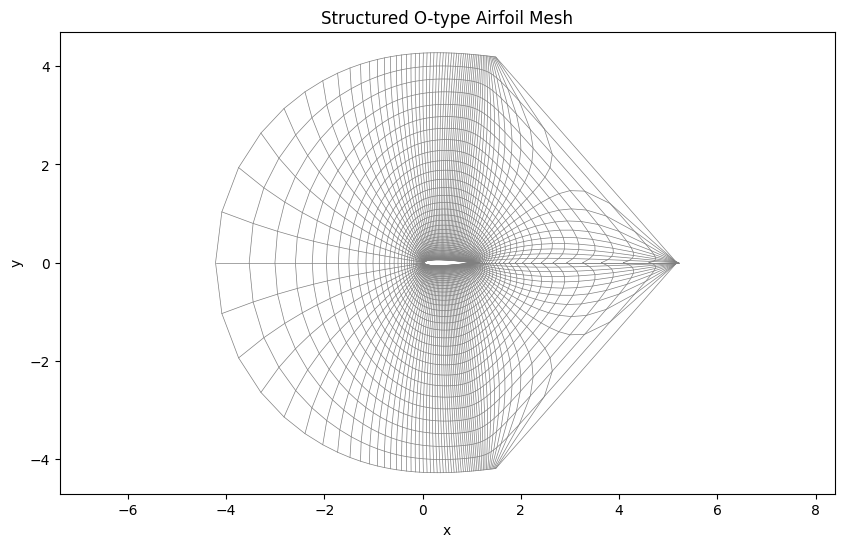

In [19]:
# Mesh resolution parameters

n_circumferential = 131  # points along airfoil (must match length of x, y arrays)
n_radial = 50            # points from airfoil to far field
chord = 1.0  # chord length is 1 m
total_radial_length = 5.0 * chord
delta = 3.5e-4  # first cell height

def total_length(q_val):
    return delta * (q_val**n_radial - 1) / (q_val - 1)

# Optimize stretching ratio
q_values = np.linspace(1.01, 1.3, 300)
lengths = [total_length(qv) for qv in q_values]
idx = (np.abs(np.array(lengths) - total_radial_length)).argmin()
q_opt = q_values[idx]
print(f"Optimized stretching ratio q: {q_opt:.4f}")

# Generate stretched radial distances
r = delta * (q_opt**np.arange(n_radial) - 1) / (q_opt - 1)

# Compute gradients (tangents)
dx = np.gradient(x)
dy = np.gradient(y)

# Compute normals by rotating tangent +90 degrees
normals_x = -dy
normals_y = dx

# Normalize normals
norms = np.sqrt(normals_x**2 + normals_y**2)
normals_x /= norms
normals_y /= norms

# Smooth normals with moving average
window = 5
normals_x_smooth = np.convolve(normals_x, np.ones(window)/window, mode='same')
normals_y_smooth = np.convolve(normals_y, np.ones(window)/window, mode='same')
norms = np.sqrt(normals_x_smooth**2 + normals_y_smooth**2)
normals_x_smooth /= norms
normals_y_smooth /= norms

# Compute centroid of airfoil
centroid_x = np.mean(x)
centroid_y = np.mean(y)

# For each point, compute vector from centroid to point
vec_x = x - centroid_x
vec_y = y - centroid_y

# Compute dot product between normal and vector from centroid
dot = normals_x_smooth * vec_x + normals_y_smooth * vec_y

# If dot < 0, normal points inward -> flip it
flip_mask = dot < 0
normals_x_smooth[flip_mask] *= -1
normals_y_smooth[flip_mask] *= -1

# --- BEGIN WAKE BLENDING ---

wake_blend_width = 10  # number of points near trailing edge to blend
flow_dir = np.array([1.0, 0.0])  # free-stream flow direction (x-axis)

for offset in range(wake_blend_width):
    alpha = offset / wake_blend_width  # 0 to 1

    # Blend near trailing edge at start (index 0)
    j = offset
    normal = np.array([normals_x_smooth[j], normals_y_smooth[j]])
    blended = (1 - alpha) * normal + alpha * flow_dir
    blended /= np.linalg.norm(blended)
    normals_x_smooth[j] = blended[0]
    normals_y_smooth[j] = blended[1]

    # Blend near trailing edge at end (index n_circumferential - 1)
    j = n_circumferential - 1 - offset
    normal = np.array([normals_x_smooth[j], normals_y_smooth[j]])
    blended = (1 - alpha) * normal + alpha * flow_dir
    blended /= np.linalg.norm(blended)
    normals_x_smooth[j] = blended[0]
    normals_y_smooth[j] = blended[1]

# Force trailing edge normals to point downstream
n_te_override = 10  # Number of points on each side to override
flow_dir_x, flow_dir_y = 1.0, 0.0  # Freestream direction

# Trailing edge indices assuming counter-clockwise coordinates
for i in range(n_te_override):
    # Pressure side (start of array)
    normals_x_smooth[i] = flow_dir_x
    normals_y_smooth[i] = flow_dir_y

    # Suction side (end of array)
    idx = -1 - i
    normals_x_smooth[idx] = flow_dir_x
    normals_y_smooth[idx] = flow_dir_y
    
# --- END WAKE BLENDING ---

# Generate mesh along smoothed normals
X = np.zeros((n_radial, n_circumferential))
Y = np.zeros((n_radial, n_circumferential))

for j in range(n_circumferential):
    for i in range(n_radial):
        X[i, j] = x[j] + r[i] * normals_x_smooth[j]
        Y[i, j] = y[j] + r[i] * normals_y_smooth[j]

# Apply elliptic (Laplace) smoothing to interior nodes
n_smooth_iters = 200
for _ in range(n_smooth_iters):
    X_new = X.copy()
    Y_new = Y.copy()
    for i in range(1, n_radial - 1):
        for j in range(1, n_circumferential - 1):
            X_new[i, j] = 0.25 * (X[i+1, j] + X[i-1, j] + X[i, j+1] + X[i, j-1])
            Y_new[i, j] = 0.25 * (Y[i+1, j] + Y[i-1, j] + Y[i, j+1] + Y[i, j-1])
    X = X_new
    Y = Y_new

# Airfoil surface (wall)
X[0, :] = x  # overwrite inner radial line with airfoil x-coords
Y[0, :] = y  # overwrite inner radial line with airfoil y-coords

# Plot mesh to visually verify
plt.figure(figsize=(10, 6))
for i in range(0, n_radial):
    plt.plot(X[i, :], Y[i, :], 'gray', lw=0.5)
for j in range(0, n_circumferential):
    plt.plot(X[:, j], Y[:, j], 'gray', lw=0.5)
plt.axis('equal')
#plt.xlim(-2, 4)
#plt.ylim(-3, 3)
plt.title("Structured O-type Airfoil Mesh")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### *Define Boundary Conditions*

In [20]:
def apply_pressure_bc(P):
    P[:, 0] = P[:, -1]      # Periodic BC
    return P

def apply_wall_velocity_bc(u, v):
# Apply only on actual wall, not cell center
    # No-slip boundary condition at airfoil surface
    u[0, :] = 0.0
    v[0, :] = 0.0
    return u, v

def apply_farfield_velocity_bc(u, v, U_inf):
    # Far-field velocity BC (outer boundary)
    u[-1, :] = U_inf
    v[-1, :] = 0
    # Perdiodic BC's
    u[:, 0] = u[:, -1]
    v[:, 0] = v[:, -1]
    return u, v

#### *Initialize*

In [21]:
# Input Parameters
U_inf = 0.5 # m/s - Free stream Velocity
ν = 1e-5 # m^2/s - Kinematic viscosity for air
ρ = 1.293 # kg/m^3 - Air density
Re = U_inf*chord/ν # Reynolds number
print ("Re =",Re) 

# Initialize variables as before
p = np.full((n_radial, n_circumferential),101325.0) # Atmospheric Pressure
u = np.full((n_radial, n_circumferential),U_inf) # Set initial guess to free stream velocity
v = np.zeros((n_radial, n_circumferential))

# Apply BCs
p = apply_pressure_bc(p)
u, v = apply_farfield_velocity_bc(u, v, U_inf)
u, v = apply_farfield_velocity_bc(u, v, U_inf)

Re = 49999.99999999999


#### *Check Mesh Quality*

In [22]:
# Y+ estimation

Cf = 0.664/(Re)**0.5
Ut = U_inf*(Cf/2)**0.5
y_firstcell = delta
y_plus = Ut*y_firstcell/ν # Should be around 1 for ideal RANS
print(f"Y+ = {y_plus:.2f}")

# Orthogonality check

# Thresholds
tolerance_deg = np.degrees(np.arccos(0.9))  # Acceptable deviation from 90° - Orthogonality of > 0.9
# Array to store angles
angles = np.zeros((n_radial - 1, n_circumferential - 1))
for j in range(n_radial - 1):
    for i in range(n_circumferential - 1):
        # Radial vector (from j to j+1)
        dr_x = X[j+1, i] - X[j, i]
        dr_y = Y[j+1, i] - Y[j, i]
        dr = np.array([dr_x, dr_y])
        # Circumferential vector (from i to i+1)
        dt_x = X[j, i+1] - X[j, i]
        dt_y = Y[j, i+1] - Y[j, i]
        dt = np.array([dt_x, dt_y])
        # Normalize vectors
        # Skip if any vector is zero-length (avoid division by zero)
        norm_dr = np.linalg.norm(dr)
        norm_dt = np.linalg.norm(dt)
        if norm_dr == 0 or norm_dt == 0:
            continue  # skip this cell
        dr_unit = dr / norm_dr
        dt_unit = dt / norm_dt
        # Dot product → cos(angle)
        cos_theta = np.clip(np.dot(dr_unit, dt_unit), -1.0, 1.0)
        angle_rad = np.arccos(cos_theta)
        angle_deg = np.degrees(angle_rad)
        # Store deviation from 90°
        angles[j, i] = abs(90 - angle_deg)
# Report max deviation
max_dev = np.max(angles)
orthogonality = np.sin(np.radians(max_dev))
print(f"Orthogonality: {orthogonality:.3f}")

# Skewness check
skewness_fvm = np.zeros((n_radial-1, n_circumferential-1))
for j in range(1, n_radial-1):
    for i in range(1, n_circumferential-1):
        xc = 0.25 * (X[j, i] + X[j+1, i] + X[j, i+1] + X[j+1, i+1])
        yc = 0.25 * (Y[j, i] + Y[j+1, i] + Y[j, i+1] + Y[j+1, i+1])
        xp = 0.5 * (X[j, i+1] + X[j+1, i+1])  # east face center
        yp = 0.5 * (Y[j, i+1] + Y[j+1, i+1])
        dx = xp - xc
        dy = yp - yc
        face_length = np.hypot(X[j+1, i+1] - X[j, i+1], Y[j+1, i+1] - Y[j, i+1])
        dist = np.hypot(dx, dy)
        skewness_fvm[j, i] = dist / face_length if face_length > 1e-12 else 0
print(f"Max FVM skewness: {np.max(skewness_fvm):.3f}")


Y+ = 0.67
Orthogonality: 1.000
Max FVM skewness: 10.968


### Processing

In the processing stage, custom functions are defined to numerically solve the incompressible Navier–Stokes equations using the Finite Volume Method (FVM) for a 2D steady-state laminar flow. Since the simulation is steady, the transient (time-dependent) terms are omitted.

Advection is handled using a MINMOD flux limiter, which offers second-order accuracy while maintaining stability. This limiter is suitable here due to the absence of abrupt geometric features that could trigger non-physical oscillations.

Diffusion is computed by evaluating velocity gradients across cell faces using standard face-based discretization.

Rhie–Chow interpolation is implemented to obtain accurate face velocities and avoid pressure–velocity decoupling, commonly known as the checkerboarding problem, which can arise with naive linear interpolation in collocated grids.

A pressure correction step ensures mass conservation by solving the Pressure Poisson Equation using the Gauss–Seidel iterative method, with an optional over-relaxation factor to enhance convergence.

Finally, the corrected pressure and velocity fields are updated after each iteration until the solution converges or the maximum set iterations are reeached.

#### *Defining Laminar Functions*

In [ ]:
def minmod(a, b): # Advection limiter
    return np.where(a * b <= 0, 0.0, np.sign(a) * np.minimum(np.abs(a), np.abs(b)))

def advection(u,v, dx_w, dx, q_opt, Ae, Aw, An, As, Vp):
# NOTE: This function uses variable names as if made for u velocity, however if the function is called with u and v places switched it can work for v velocity

# The MINMOD scheme was chosen for the advection portion

    n_radial, n_circumferential = u.shape
    lx = (0.5*dx_w)/dx # Percentage of distance between centers belonging to current cell
    ly = 0.5*q_opt # Percentage of distance between centers belonging to current cel

    # Initialize variables
    flux_uue = np.zeros_like(u)
    flux_uve = np.zeros_like(u)
    flux_uuw = np.zeros_like(u)
    flux_uvw = np.zeros_like(u)
    flux_uun = np.zeros_like(u)
    flux_uvn = np.zeros_like(u)
    flux_uus = np.zeros_like(u)
    flux_uvs = np.zeros_like(u)

    for j in range (0, n_radial-1):
        for i in range (0, n_circumferential-1):
            # East face

            # Compute Cell-Centered Gradients
            forward = u[j,i+1] - u[j,i]
            if i == 0:
                backward = u[j,i] - u[j,-2] # Periodicity
            else:
                backward = u[j,i] - u[j,i-1]
            r = backward/(forward + 1e-12) # Ratio of succesive gradients
            #ψ = np.maximum(0.0, np.minimum(1, r)) # MINMOD limiter
            slope = minmod(forward, backward)
            # Reconstruct Left and Right States at Faces
            u_L = u[j,i] + slope # Flow coming from left cell
            u_R = u[j,i] - slope # Flow coming from right cell
            # Determine direction of the flow
            u_e = lx[j,i]*u[j,i] + (1-lx[j,i])*u[j,i+1] # Linear interpolation
            if u_e > 0:
                u_upwind = u_L
            else:
                u_upwind = u_R 
            # Calculate flux
            flux_uue[j,i] = u_e * u_upwind
            v_e = lx[j,i]*v[j,i] + (1-lx[j,i])*v[j,i+1] # Linear interpolation
            flux_uve[j,i] = v_e * u_upwind

            # South face

            # Compute Cell-Centered Gradients
            forward = u[j+1,i] - u[j,i]
            if j == 0:
                backward = u[j,i] - 0 # Set non-slip wall velocity
            else:
                backward = u[j,i] - u[j-1,i]
            r = backward/(forward + 1e-12) # Ratio of succesive gradients
            #ψ = np.maximum(0.0, np.minimum(1, r)) # MINMOD limiter
            slope = minmod(forward, backward)
            # Reconstruct Left and Right States at Faces
            u_L = u[j,i] + slope # Flow coming from lower cell
            u_U = u[j,i] - slope # Flow coming from upper cell
            # Determine direction of the flow
            if j == 0:
                u_s = ly*u[j,i] + (1-ly)* 0 # Linear interpolation (Set non-slip wall velocity)
                v_s = ly*v[j,i] + (1-ly)* 0 # Linear interpolation (Set non-slip wall velocity)
            else:
                u_s = (1-ly)*u[j,i] + ly*u[j-1,i] # Linear interpolation
                v_s = (1-ly)*v[j,i] + ly*v[j-1,i] # Linear interpolation
            if u_s > 0:
                u_upwind = u_L
            else:
                u_upwind = u_U 
            # Calculate flux
            flux_uus[j,i] = u_s * u_upwind
            flux_uvs[j,i] = v_s * u_upwind

    # Set Periodicity

    flux_uue[:,-1] = flux_uue[:,0]
    flux_uve[:,-1] = flux_uve[:,0]
    flux_uue[-1,:] = flux_uue[-2,0] # Zero gradient in farfield
    flux_uve[-1,:] = flux_uve[-2,0] # Zero gradient in farfield
    flux_uuw[:,1:] = flux_uue[:,:-1]
    flux_uuw[:,0] = flux_uuw[:,-1]
    flux_uvw[:,1:] = flux_uve[:,:-1]
    flux_uvw[:,0] = flux_uvw[:,-1]

    flux_uus[:,-1] = flux_uus[:,0]
    flux_uvs[:,-1] = flux_uvs[:,0]
    flux_uus[-1,:] = flux_uus[-2,0] # Zero gradient in farfield
    flux_uvs[-1,:] = flux_uvs[-2,0] # Zero gradient in farfield
    flux_uun[:-1,:] = flux_uus[1:,:]
    flux_uun[-1,:] = flux_uun[-2,:] # Zero gradient in farfield
    flux_uvn[:-1,:] = flux_uvs[1:,:]
    flux_uvn[-1,:] = flux_uvn[-2,:] # Zero gradient in farfield

    # Multiply fluxes by respective face area
    flux_uue *= Ae
    flux_uve *= Ae
    flux_uuw *= Aw
    flux_uvw *= Aw
    flux_uun *= An
    flux_uvn *= An
    flux_uus *= As
    flux_uvs *= As

    adv_u = (flux_uue + flux_uve - flux_uuw - flux_uvw + flux_uun + flux_uvn - flux_uus - flux_uvs)/Vp

    return adv_u

def diffusion(u, dx, dy, Ae, Aw, An, As, ν):
# NOTE: This function uses variable names as if made for u velocity, however if the function is called with u and v places switched it can work for v velocity

    n_radial, n_circumferential = u.shape
    diff = np.zeros([n_radial,n_circumferential])

    for j in range(0, n_radial - 1):
        for i in range(0, n_circumferential-1):
            # Compute fluxes
            diff_e = ν * (u[j,i+1] - u[j,i])/dx[j,i] * Ae[j,i]   # East face flux
            diff_n = ν * (u[j+1,i] - u[j,i])/dy[j,i] * An[j,i]   # North face flux
            if i == 0:
                diff_w = ν * (u[j,-2] - u[j,i])/dx[j,i] * Aw[j,i]   # West face flux (Periodicity)
            else:
                diff_w = ν * (u[j,i-1] - u[j,i])/dx[j,i] * Aw[j,i]   # West face flux
            if j == 0:
                diff_s = ν * (0 - u[j,i])/dy[j,i] * As[j,i]   # South face flux (Wall velocity = 0)
            else:
                diff_s = ν * (u[j-1,i] - u[j,i])/dy[j,i] * As[j,i]   # South face flux
            diff[j,i] = diff_e + diff_n - diff_w - diff_s

    # Set Periodicity
    diff[:,-1] = diff[:,0]
    diff[-1,:] = diff[-2,:]
    return diff

def compute_divergence(u, v, dx_e, dx_w, dy_n, dy_s):
    # Compute ∇·u on a structured grid using face-based differences.

    ny, nx = u.shape
    div = np.zeros_like(u)
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            dudx = (u[j,i+1]-u[j,i-1])/(dx_e[j,i] + dx_w[j,i])
            dvdy = (v[j+1,i]-v[j-1,i])/(dy_n[j,i] + dy_s[j,i])
            div[j, i] = dudx + dvdy
    return div

def Rhie_Chow_Int(q_opt, dx, dy, dx_w, n_radial, n_circumferential, u, v, p, Ap, U_inf):

    # The Rhie-Chow interpolation is used to find the face velocities without causing checkerboarding issues

    lx = (0.5*dx_w)/dx # Percentage of distance between centers belonging to current cell
    ly = 0.5*q_opt # Percentage of distance between centers belonging to current cel

    uf_n = np.zeros_like(u)
    uf_s = np.zeros_like(u)
    uf_e = np.zeros_like(u)
    uf_w =  np.zeros_like(u)
    vf_n = np.zeros_like(v)
    vf_s = np.zeros_like(v)
    vf_e = np.zeros_like(v)
    vf_w = np.zeros_like(v)

    # Set Periodic Boundaries
    p_old = p.copy()
    p = np.zeros([n_radial, n_circumferential + 2])
    p[:,:-2] = p_old
    p[:,-2:] = p_old[:,1:2]
    u_old = u.copy()
    u = np. zeros([n_radial,n_circumferential+1])
    u[:,:-1] = u_old
    u[:,-1] = u_old[:,1]
    v_old = v.copy()
    v = np. zeros([n_radial,n_circumferential+1])
    v[:,:-1] = v_old
    v[:,-1] = v_old[:,1]
    dx_old = dx.copy()
    dx = np.zeros([n_radial, n_circumferential + 2])
    dx[:,:-2] = dx_old
    dx[:,-2:] = dx_old[:,1:2]
    Ap_old = Ap.copy()
    Ap = np.zeros([n_radial+1,n_circumferential+1])
    Ap[:-1,:-1] = Ap_old
    Ap[:-1,-1] = Ap_old[:,-1]
    Ap[-1,:-1] = Ap_old[-1,:]

    # East faces
    for i in range(0,n_circumferential):
        for j in range(1,n_radial):
            uf_e_bar = lx[j,i]*u[j,i] + (1-lx[j,i])*u[j,i+1] # Linear interpolation
            vf_e_bar = lx[j,i]*v[j,i] + (1-lx[j,i])*v[j,i+1] # Linear interpolation
            dpdx_fe = (p[j,i+1] - p[j,i])/dx[j,i] # Pressure Gradient Face
            if i == 0:
                dpdx_P = (p[j,i+1] - p[j,-2]) / (dx[j,i+1] + dx[j,-2]) # Pressure Gradient Current Cell Center (Periodicity)
            else:
                dpdx_P = (p[j,i+1] - p[j,i-1]) / (dx[j,i+1] + dx[j,i-1]) # Pressure Gradient Current Cell Center
            dpdx_E = (p[j,i+2] - p[j,i])/(dx[j,i] + dx[j,i+2]) # Pressure Gradient East Cell Center
            dpdx_fe_bar = lx[j,i]*dpdx_P + (1-lx[j,i])*dpdx_E
            Ap_face = 0.5 * (Ap[j,i] + Ap[j,i+1])
            df_e = 1/Ap_face
            uf_e[j,i] = uf_e_bar - df_e*(dpdx_fe - dpdx_fe_bar)
            vf_e[j,i] = vf_e_bar - df_e*(dpdx_fe - dpdx_fe_bar)

    # South Faces
    for i in range(1,n_circumferential):
        for j in range(1,n_radial-1):
            uf_s_bar = ly*u[j,i] + (1-ly)*u[j-1,i] # Linear interpolation
            vf_s_bar = ly*v[j,i] + (1-ly)*v[j-1,i] # Linear interpolation
            dpdy_fs = (p[j-1,i] - p[j,i])/dy[j-1,i] # Pressure Gradient Face
            dpdy_P = (p[j+1,i] - p[j-1,i])/(dy[j-1,i] + dy[j+1,i]) # Pressure Gradient Current Cell Center
            if j == 1:
                dpdy_S = (p[j-1,i]-p[j,i])/(dy[j-1,i] + dy[j,i]) # Pressure Gradient South Cell Center (Neumann 0 pressure gradient at wall)
            else:
                dpdy_S = (p[j-2,i] - p[j,i])/(dy[j,i] + dy[j-2,i]) # Pressure Gradient South Cell Center
            dpdy_fs_bar = ly*dpdy_P + (1-ly)*dpdy_S
            Ap_face = 0.5 * (Ap[j,i] + Ap[j-1,i])
            df_s = 1/Ap_face
            uf_s[j,i] = uf_s_bar - df_s*(dpdy_fs - dpdy_fs_bar)
            vf_n[j,i] = vf_s_bar - df_s*(dpdy_fs - dpdy_fs_bar)

    # Apply BC's and Periodicity
    uf_s, vf_s = apply_wall_velocity_bc(uf_s, vf_s)
    uf_s, vf_s = apply_farfield_velocity_bc(uf_s, vf_s, U_inf)
    uf_n[:-1,:] = uf_s[1:,:]
    uf_n, vf_n = apply_farfield_velocity_bc(uf_n, vf_n, U_inf)
    uf_w[:,1:] = uf_e[:,:-1]
    vf_w[:,1:] = vf_e[:,:-1]
    uf_w[:,-1] = uf_w[:,0]
    
    # The velocity fluxes are calculated on all four faces for both u and v because the grid is not cartesian (completely straight faces and cells)
    return uf_n, uf_e, vf_n, vf_e, uf_s, vf_s, uf_w, vf_w

def compute_divergence_faces(uf_e, uf_w, uf_n, uf_s, vf_e, vf_w, vf_n, vf_s, Ae, Aw, An, As, Vp):

    # Compute ∇·u using face velocities

    n_radial, n_circ = Vp.shape
    div = np.zeros_like(Vp)

    for j in range(1, n_radial - 1):
        for i in range(1, n_circ - 1):
            flux_e = (uf_e[j,i]+vf_e[j,i]) * Ae[j,i]
            flux_w = (uf_w[j,i]+vf_w[j,i]) * Aw[j,i]
            flux_n = (uf_n[j,i]+vf_n[j,i]) * An[j,i]
            flux_s = (uf_s[j,i]+vf_s[j,i]) * As[j,i]

            div[j,i] = (flux_e - flux_w + flux_n - flux_s) / Vp[j,i]

    return div

def pressure_correction_GS(p_prime, div, dx, dy, ρ, tol=1e-6, max_iter=500, β = 1.0):

    # The pressure poisson equation is solved with a Gauss-Seidel approach (with the optional over relaxation factor to speed up convergence)

    ny, nx = p_prime.shape
    res_it = np.zeros_like(p_prime)
    max_res = 1
    it = 0

    while it < max_iter and max_res > tol:

        for j in range(0, ny-1):
            for i in range(0, nx-1):
                denominator = 2*(1/dx[j,i]**2 + 1/dy[j,i]**2)
                # Scale divergence source term by density
                b =ρ * div[j, i]
                if j == 0:
                    if i == 0:
                        numerator = (1/dx[j,i]**2)*(p_prime[j,i+1]-p_prime[j,-2]) + (1/dy[j,i]**2)*(p_prime[j+1,i]-p_prime[0,i]) - b
                    else:
                        numerator = (1/dx[j,i]**2)*(p_prime[j,i+1]-p_prime[j,i-1]) + (1/dy[j,i]**2)*(p_prime[j+1,i]-p_prime[0,i]) - b
                else:
                    if i == 0:
                        numerator = (1/dx[j,i]**2)*(p_prime[j,i+1]-p_prime[j,-2]) + (1/dy[j,i]**2)*(p_prime[j+1,i]-p_prime[j-1,i]) - b
                    else:
                        numerator = (1/dx[j,i]**2)*(p_prime[j,i+1]-p_prime[j,i-1]) + (1/dy[j,i]**2)*(p_prime[j+1,i]-p_prime[j-1,i]) - b
                p_new = numerator/denominator
                p_new = β*p_new + (1-β)*p_prime[j,i]

                res = abs(p_new - p_prime[j, i])
                res_it[j,i] = res
                p_prime[j, i] = p_new

        p_prime[:,-1] = p_prime[:,0] # Periodicity
        p_prime[-1,:] = p_prime[-2,0] # Zero gradient in farfield
        p_prime = apply_pressure_bc(p_prime)
                
        it += 1
        max_res = np.max(np.abs(res_it))
        #print(max_res)
    if it == max_iter:
        print(f"GS reached max iterations ({max_iter}) with residual {max_res:.2e}")

    return p_prime

def velocity_pressure_correction(u, v, p, p_prime, U_inf, dx, dy, ρ, αp=0.3):

    # Use pressure correction to correct variables
    
    ny, nx = p.shape
    u_corr = np.zeros_like(u)
    v_corr = np.zeros_like(v)

    for j in range(0, ny - 1):
        for i in range(0, nx - 1):
            if i == 0:
                dpdx = (p_prime[j, i + 1] - p_prime[j, -2]) / (dx[j,-2] + dx[j,i+1]) # Periodicity
            else:
                dpdx = (p_prime[j, i + 1] - p_prime[j, i - 1]) / (dx[j,i-1] + dx[j,i+1])
            if j == 0:
                dpdy = (p_prime[j + 1, i] - 0) / (dy[j,i] + dy[j+1,i]) # No Pressure correction inside wall
            else:    
                dpdy = (p_prime[j + 1, i] - p_prime[j - 1, i]) / (dy[j-1,i] + dy[j+1,i])

            u_corr[j, i] = -dpdx / ρ
            v_corr[j, i] = -dpdy / ρ

    u_corr[j,-1] = u_corr[j,0] # Periodicity
    u_corr[-1,j] = u_corr[-2,j] # Zero gradient in farfield
    v_corr[j,-1] = v_corr[j,0] # Periodicity
    v_corr[-1,j] = v_corr[-2,j] # Zero gradient in farfield

    u_new = u + αp * u_corr
    v_new = v + αp * v_corr
    p_new = p + αp * p_prime

    u_new, v_new = apply_farfield_velocity_bc(u_new, v_new, U_inf)
    p_new = apply_pressure_bc(p_new)

    return u_new, v_new, p_new



#### *Solving Laminar flow equations*

In [24]:
it = 0
maxit = 750 # Maximum amount of iterations
tol = 1e-6 # Error Tolerance
error = 1000 # Error initial guess
p_prime = np.zeros_like(p)

# Create a vector for errors to plot later
errors_u = []
errors_v = []
errors_p = []

# Determine distances between faces and cell centers

# Define dx and dy for the non-uniform grid using Euclidean distance
dx_e = np.zeros([n_radial, n_circumferential])
dx_w = np.zeros([n_radial, n_circumferential])
dy_n = np.zeros([n_radial, n_circumferential])
dy_s = np.zeros([n_radial, n_circumferential])

# EAST/WEST distances (along circumferential θ)
# Distance between point (i,j) and (i,j+1)
dx_e[:, :-1] = np.sqrt((X[:, 1:] - X[:, :-1])**2 + (Y[:, 1:] - Y[:, :-1])**2)
# Wrap-around distance for last circumferential edge
dx_e[:, -1] = np.sqrt((X[:, 0] - X[:, -1])**2 + (Y[:, 0] - Y[:, -1])**2)
# WEST distances are the east distances shifted left by 1
dx_w[:, 1:] = dx_e[:, :-1]
# For the first circumferential column, west neighbor is the last circumferential column (due to periodicity)
dx_w[:, 0] = dx_e[:, -1]

# NORTH/SOUTH distances (along r)
dy_n[:-1, :] = np.sqrt((X[1:, :] - X[:-1, :])**2 + (Y[1:, :] - Y[:-1, :])**2)
dy_s[1:, :] = dy_n[:-1, :]
dy_n[-1, :] = dy_n[-2, :]   # copy from second last row
dy_s[0, :]  = dy_s[1, :]    # copy from second row

# Averaged dx, dy (distances between centers)
dx = 0.5 * (dx_e + dx_w)
dy = 0.5 * (dy_n + dy_s)

Vp = dx_w*dy_s # Volume of the cell

# Determine face lengths and normals

# Initialize variables
Ae = np.zeros_like(X)
Aw = np.zeros_like(X)
An = np.zeros_like(X)
As = np.zeros_like(X)
# Face normals
nx_e = np.zeros_like(X)
ny_e = np.zeros_like(X)
nx_w = np.zeros_like(X)
ny_w = np.zeros_like(X)
nx_n = np.zeros_like(X)
ny_n = np.zeros_like(X)
nx_s = np.zeros_like(X)
ny_s = np.zeros_like(X)
# Loop over interior cells
for i in range(1, n_radial - 1):
    for j in range(1, n_circumferential - 1):
        # East face vector
        dx_e_vec = X[i, j+1] - X[i, j]
        dy_e_vec = Y[i, j+1] - Y[i, j]
        Ae[i, j] = np.sqrt(dx_e_vec**2 + dy_e_vec**2)
        nx_e[i, j] = dy_e_vec / Ae[i, j]
        ny_e[i, j] = -dx_e_vec / Ae[i, j]  # +90° rotation
        # West face vector
        dx_w_vec = X[i, j] - X[i, j-1]
        dy_w_vec = Y[i, j] - Y[i, j-1]
        Aw[i, j] = np.sqrt(dx_w_vec**2 + dy_w_vec**2)
        nx_w[i, j] = dy_w_vec / Aw[i, j]
        ny_w[i, j] = -dx_w_vec / Aw[i, j]
        # North face vector
        dx_n_vec = X[i+1, j] - X[i, j]
        dy_n_vec = Y[i+1, j] - Y[i, j]
        An[i, j] = np.sqrt(dx_n_vec**2 + dy_n_vec**2)
        nx_n[i, j] = dy_n_vec / An[i, j]
        ny_n[i, j] = -dx_n_vec / An[i, j]
        # South face vector
        dx_s_vec = X[i, j] - X[i-1, j]
        dy_s_vec = Y[i, j] - Y[i-1, j]
        As[i, j] = np.sqrt(dx_s_vec**2 + dy_s_vec**2)
        nx_s[i, j] = dy_s_vec / As[i, j]
        ny_s[i, j] = -dx_s_vec / As[i, j]
Ap = ν * ρ * (Ae / dx_e + Aw / dx_w + An / dy_n + As / dy_s) + 1e-6

# Iterate to solve fuid flow

while error > tol and it < maxit:
    # Save old fields for error check
    u_old = u.copy()
    v_old = v.copy()
    p_old = p.copy()

    # 1) Advection step (MINMOD) for u and v
    adv_u = advection(u,v, dx_w, dx, q_opt, Ae, Aw, An, As, Vp)
    adv_v = advection(v,u, dx_w, dx, q_opt, Ae, Aw, An, As, Vp)

    # 2) Diffusion step for u and v
    diff_u = diffusion(u, dx, dy, Ae, Aw, An, As, ν)
    diff_v = diffusion(v, dx, dy, Ae, Aw, An, As, ν)

    # Update velocities
    u = u -  adv_u + diff_u
    v = v -  adv_v + diff_v

    """"
    Compute divergence and plot it (for visualisation purposes)

    div = compute_divergence(u, v, dx_e, dx_w, dy_n, dy_s)
    loc = np.argmax(np.abs(div))
    loc_2d = np.unravel_index(loc, div.shape)
    j_max, i_max = map(int, loc_2d)
    print(f"Max ∇·u before rhie chow = {np.max(np.abs(div)):.2e} at cell (j = {j_max}, i = {i_max})")
    #if it != 0:
    plt.figure(figsize=(10, 4))
    levels = np.linspace(np.min(div), np.max(div), 100)
    cp = plt.contourf(div.T, levels=levels, cmap='seismic')  # transpose for [i,j] to [x,y] orientation
    plt.colorbar(cp, label='Divergence')
    plt.title("Divergence Field")
    plt.xlabel("Radial index (j)")
    plt.ylabel("Circumferential index (i)")
    plt.show()
    """

    # 3) Use Rhie-Chow Interpolation to get face velocities
    uf_n, uf_e, vf_n, vf_e, uf_s, vf_s, uf_w, vf_w = Rhie_Chow_Int(q_opt, dx, dy, dx_w, n_radial, n_circumferential, u, v, p, Ap, U_inf)

    
    # 4) Pressure correction step: solve pressure correction equation

    # Compute source term to avoid divergence (And use in pressure correction)
    rhs = compute_divergence_faces(uf_e, uf_w, uf_n, uf_s, vf_e, vf_w, vf_n, vf_s, Ae, Aw, An, As, Vp)
    """"
    Compute divergence and plot it (for visualisation purposes)

    loc = np.argmax(np.abs(rhs))
    loc_2d = np.unravel_index(loc, rhs.shape)
    j_max, i_max = map(int, loc_2d)
    print(f"Max ∇·u before correction = {np.max(np.abs(rhs)):.2e} at cell (j = {j_max}, i = {i_max})")
    plt.figure(figsize=(10, 4))
    levels = np.linspace(np.min(rhs), np.max(rhs), 100)
    cp = plt.contourf(rhs.T, levels=levels, cmap='seismic')  # transpose for [i,j] to [x,y] orientation
    plt.colorbar(cp, label='Divergence')
    plt.title("Divergence Field")
    plt.xlabel("Radial index (j)")
    plt.ylabel("Circumferential index (i)")
    #plt.xlim(0,4)
    #plt.ylim(0,5)
    plt.show()
    """
    p_prime = pressure_correction_GS(p_prime, rhs, dx, dy, ρ, tol=1e-6, max_iter=1000, β =1)

    # 5) Velocity and pressure correction step
    u, v, p = velocity_pressure_correction(u, v, p, p_prime, U_inf, dx, dy, ρ, αp=0.3)

    """
    Compute divergence and plot it (for visualisation purposes)

    div = compute_divergence(u, v, dx_e, dx_w, dy_n, dy_s)
    loc = np.argmax(np.abs(div))
    loc_2d = np.unravel_index(loc, div.shape)
    j_max, i_max = map(int, loc_2d)
    print(f"Max ∇·u after correction = {np.max(np.abs(div)):.2e} at cell (j = {j_max}, i = {i_max})")
    plt.figure(figsize=(10, 4))
    levels = np.linspace(np.min(div), np.max(div), 100)
    cp = plt.contourf(div.T, levels=levels, cmap='seismic')  # transpose for [i,j] to [x,y] orientation
    plt.colorbar(cp, label='Divergence')
    plt.title("Divergence Field")
    plt.xlabel("Radial index (j)")
    plt.ylabel("Circumferential index (i)")
    plt.show()
    """

    # 7) Compute error
    error_u = np.max(np.abs(u - u_old))
    error_v = np.max(np.abs(v - v_old))
    error_p = np.max(np.abs(p - p_old))
    error = max(error_u, error_v, error_p)
    errors_u.append(error_u)
    errors_v.append(error_v)
    errors_p.append(error_p)

    it += 1
    print(f"Iteration {it}: error = {error:.3e}")

# Plot errors against iteration counter
plt.plot(errors_u, label='Error u')
plt.plot(errors_v, label='Error v')
plt.plot(errors_p, label='Error p')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of velocity and pressure')
plt.xlim(0,5)
plt.show()

KeyboardInterrupt: 

### Post Processing

#### *Check for Divergence*